In [ ]:
# Pin to a consistent Qiskit 2.x stack and force a restart
%pip uninstall -y qiskit-terra qiskit qiskit-aer qiskit-machine-learning
%pip install -q qiskit==2.0.1 qiskit-aer==0.17.0 qiskit-machine-learning==0.8.2 scikit-learn pandas
import os; os.kill(os.getpid(), 9)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.6/231.6 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 4.3 MB/s eta 0:00:00


In [ ]:
# %pip install -q qiskit-terra scipy scikit-learn pandas


In [ ]:
import qiskit, qiskit_aer, qiskit_machine_learning, qiskit.version
from sklearn.metrics import confusion_matrix


In [ ]:
from google.colab import files
import io
import pandas as pd

# selecting the csv from files (choose the training data)
uploaded = files.upload()

fname = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[fname]))

# df is now the uploaded file
df.head()

Saving DIA_trainingset_RDKit_descriptors.csv to DIA_trainingset_RDKit_descriptors.csv


,Label,SMILES,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0,COC(=O)N(C)c1c(N)nc(nc1N)c2nn(Cc3ccccc3F)c4ncc...,1.821,1266.407,22.121,16.781,16.781,14.901,9.203,9.203,...,0,0,0,0,0,0,0,0,0,0
1,0,C[C@H](N(O)C(=O)N)c1cc2ccccc2s1,2.363,490.434,11.707,8.752,9.569,7.592,4.854,5.670,...,0,0,0,0,0,0,0,1,0,1
2,0,C[N+](C)(C)CC(=O)[O-],3.551,93.092,6.784,5.471,5.471,3.417,2.420,2.420,...,0,0,0,0,0,0,0,0,0,0
3,1,CC(C)n1c(\C=C\[C@H](O)C[C@H](O)CC(=O)O)c(c2ccc...,2.076,1053.003,21.836,16.995,16.995,14.274,9.926,9.926,...,0,0,0,0,0,0,0,0,0,0
4,1,C\C(=C(\C#N)/C(=O)Nc1ccc(cc1)C(F)(F)F)\O,2.888,549.823,14.629,9.746,9.746,8.752,5.040,5.040,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, SparsePauliOp
from qiskit.circuit.library import ZZFeatureMap, TwoLocal



# Load & preprocess
df = pd.read_csv('DIA_trainingset_RDKit_descriptors.csv')
df.drop(columns=['Shorthand','Target'], inplace=True, errors='ignore')
if 'Label' not in df:
    numcol = df.select_dtypes(include=[np.number]).columns[0]
    df['Label'] = (df[numcol] > df[numcol].median()).astype(int)

X = df.drop(columns=['SMILES','Label']).values.astype(np.float32)
y = df['Label'].to_numpy(dtype=int)
X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0) + 1e-8)

# PCA → 2 dims (2 qubits)
X2 = PCA(n_components=3).fit_transform(X)

# Split
Xtr, Xte, ytr, yte = train_test_split(
    X2, y, test_size=0.2, stratify=y, random_state=42
)

# Build circuit: ZZFeatureMap + TwoLocal ansatz
nq     = 3
fmap   = ZZFeatureMap(feature_dimension=nq, reps=3)
ansatz = TwoLocal(
    num_qubits=nq,
    rotation_blocks=['ry', 'rz'],
    entanglement_blocks=['cz'],
    reps=3
)
# Pre-bind feature maps
param_list = list(fmap.parameters)
fmap_train = [
    fmap.assign_parameters({param_list[i]: x[i] for i in range(len(param_list))})
    for x in Xtr
]
fmap_test = [
    fmap.assign_parameters({param_list[i]: x[i] for i in range(len(param_list))})
    for x in Xte
]

# Define measurement Z⊗Z
Z2 = SparsePauliOp.from_list([('ZZ', 1)])

# Cross-entropy loss
ansatz_params = list(ansatz.parameters)
def ce_loss(weights):
    total = 0
    for bind_circ, label in zip(fmap_train, ytr):
        ans_map = {ansatz_params[i]: weights[i] for i in range(len(ansatz_params))}
        full   = bind_circ.compose(ansatz.assign_parameters(ans_map))
        sv     = Statevector.from_instruction(full)
        exp_val = sv.expectation_value(Z2).real
        p = np.clip((1 - exp_val) / 2, 1e-10, 1 - 1e-10)
        total += label * np.log(p) + (1 - label) * np.log(1 - p)
    return -total / len(ytr)

# Optimize with COBYLA
init = np.zeros(len(ansatz_params))
res  = minimize(ce_loss, init, method='COBYLA', options={'maxiter':300})
opt_w = res.x
print(f"🔧 Training loss: {res.fun:.4f}")

# Evaluate
y_pred = []
for bind_circ in fmap_test:
    ans_map = {ansatz_params[i]: opt_w[i] for i in range(len(ansatz_params))}
    full   = bind_circ.compose(ansatz.assign_parameters(ans_map))
    sv     = Statevector.from_instruction(full)
    exp_val = sv.expectation_value(Z2).real
    p = (1 - exp_val) / 2
    y_pred.append(int(p > 0.5))

acc = accuracy_score(yte, y_pred)
print(f"✅ 3-qubit VQC accuracy: {acc:.2%}")

cm = confusion_matrix(yte, y_pred)

# Pretty-print as a DataFrame
cmdf = pd.DataFrame(
    cm,
    index=['True 0','True 1'],
    columns=['Pred 0','Pred 1']
)
print(cmdf)


🔧 Training loss: 0.6601
✅ 3-qubit VQC accuracy: 60.42%
        Pred 0  Pred 1
True 0      50      22
True 1      16       8


## Now that we have the qc stuff, let's augment it with some classical. Two qubits helped us progress with 2 PC, but we can do more. We tried running 3 PC, but that took longer and didn't give us much of an improvement. 4 qubits didn't run.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble    import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics     import accuracy_score, confusion_matrix, roc_auc_score

# Classical LR on PCA features 
lr = LogisticRegression(solver='lbfgs', max_iter=500)
lr.fit(Xtr, ytr)

p_class_tr = lr.predict_proba(Xtr)[:,1]
p_class_te = lr.predict_proba(Xte)[:,1]

# Compute QC probabilities on train & test 
def compute_qc_probs(fmap_list):
    probs = []
    for bind_circ in fmap_list:
        full  = bind_circ.compose(ansatz.assign_parameters({ansatz_params[i]: opt_w[i] for i in range(len(opt_w))}))
        sv = Statevector.from_instruction(full)
        exp_val = sv.expectation_value(Z2).real
        probs.append((1 - exp_val) / 2)
    return np.array(probs)

p_qc_tr = compute_qc_probs(fmap_train)
p_qc_te = compute_qc_probs(fmap_test)

# Meta‐LR stacking just on [p_class, p_qc] 
meta_Xtr = np.column_stack((p_class_tr, p_qc_tr))
meta_Xte = np.column_stack((p_class_te, p_qc_te))

meta_lr = LogisticRegression(solver='lbfgs', max_iter=200)
meta_lr.fit(meta_Xtr, ytr)

y_meta_pred = meta_lr.predict(meta_Xte)
print("Meta-LR Accuracy:", accuracy_score(yte, y_meta_pred))
print(pd.DataFrame(
    confusion_matrix(yte, y_meta_pred),
    index=['True 0','True 1'], columns=['Pred 0','Pred 1']
))

# Enriched RF on [full descriptors + PCA + probs + interaction]
#   Re-split the ORIGINAL descriptor matrix X
X_full_tr, X_full_te, y_tmp1, y_tmp2 = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
# sanity check: y_tmp1 == ytr, y_tmp2 == yte

#   Build the interaction term
interaction_tr = (p_class_tr * p_qc_tr).reshape(-1,1)
interaction_te = (p_class_te * p_qc_te).reshape(-1,1)

meta_all_tr = np.hstack([
    X_full_tr,                     # all original D descriptors
    Xtr,                           # 3 PCA dims
    p_class_tr.reshape(-1,1),      # LR probability
    p_qc_tr.reshape(-1,1),         # VQC probability
    interaction_tr
])

meta_all_te = np.hstack([
    X_full_te,
    Xte,
    p_class_te.reshape(-1,1),
    p_qc_te.reshape(-1,1),
    interaction_te
])

# train & evaluate RF
rf_all = RandomForestClassifier(
    n_estimators=200,
    max_depth=5,
    class_weight={0:1, 1:3},  # heavier penalty on false-negatives
    random_state=42
)


Meta-LR Accuracy: 0.75
        Pred 0  Pred 1
True 0      72       0
True 1      24       0


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats          import randint
from sklearn.metrics      import roc_auc_score

# Define the parameter distributions
param_dist = {
    'n_estimators':    randint(100, 800),
    'max_depth':       [None, 5, 10, 20],
    'min_samples_leaf':[1, 2, 5, 10],
    'class_weight':    [{0:1,1:2},{0:1,1:3},{0:1,1:4}, 'balanced']
}

# set up the randomized search
rf = RandomForestClassifier(random_state=42)
search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=20,               # try 20 different combos
    scoring='roc_auc',
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Run it on your training meta_all_tr
search.fit(meta_all_tr, ytr)
print("Best params:", search.best_params_)

# Evaluate the best estimator on your test set
best_rf = search.best_estimator_
p_opt_te = best_rf.predict_proba(meta_all_te)[:,1]
y_opt_pred = (p_opt_te > 0.5).astype(int)

print(f"\nOptimized RF accuracy:  {accuracy_score(yte, y_opt_pred):.2%}")
print(f"Optimized RF ROC-AUC:   {roc_auc_score(yte, p_opt_te):.3f}")
print(pd.DataFrame(
    confusion_matrix(yte, y_opt_pred),
    index=['True 0','True 1'], columns=['Pred 0','Pred 1']
))


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 574}

Optimized RF accuracy:  85.42%
Optimized RF ROC-AUC:   0.869
        Pred 0  Pred 1
True 0      71       1
True 1      13      11


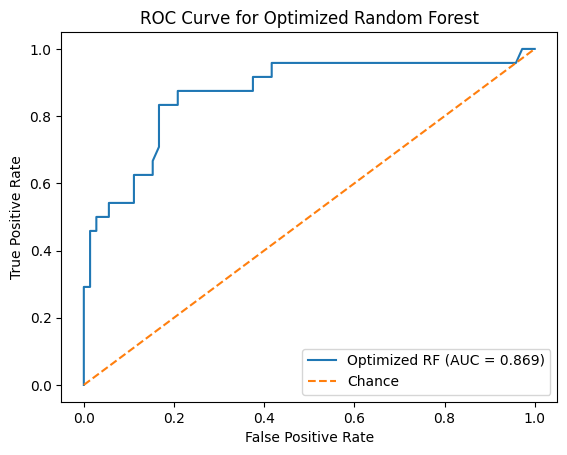

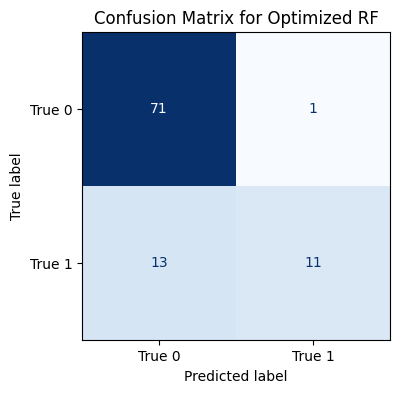

In [ ]:
# === Plot ROC for the optimized RandomForest ===
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

# Get probabilities from best_rf (from search.best_estimator_)
p_opt_te = best_rf.predict_proba(meta_all_te)[:, 1]

# Compute ROC curve and AUC
fpr_opt, tpr_opt, _ = roc_curve(yte, p_opt_te)
roc_auc_opt = auc(fpr_opt, tpr_opt)

# Plot
plt.figure()
plt.plot(fpr_opt, tpr_opt, label=f'Optimized RF (AUC = {roc_auc_opt:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Optimized Random Forest')
plt.legend()
plt.show()

# Confusion Matrix —
y_opt_pred = best_rf.predict(meta_all_te)
cm = confusion_matrix(yte, y_opt_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['True 0','True 1'])

fig, ax = plt.subplots(figsize=(5,4))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
plt.title('Confusion Matrix for Optimized RF')
plt.show()


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats          import randint
from sklearn.metrics      import roc_auc_score

# Define the parameter distributions
param_dist = {
    'n_estimators':    randint(100, 800),
    'max_depth':       [None, 5, 10, 20],
    'min_samples_leaf':[1, 2, 5, 10],
    'class_weight':    [{0:1,1:2},{0:1,1:3},{0:1,1:4}, 'balanced']
}

# Set up the randomized search with RFC
rf = RandomForestClassifier(random_state=42)
search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=20,               # try 20 different combos
    scoring='roc_auc',
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Run it on your training meta_all_tr
search.fit(meta_all_tr, ytr)
print("Best params:", search.best_params_)

# Evaluate the best estimator on your test set
best_rf = search.best_estimator_
p_opt_te = best_rf.predict_proba(meta_all_te)[:,1]
y_opt_pred = (p_opt_te > 0.5).astype(int)

print(f"\nOptimized RF accuracy:  {accuracy_score(yte, y_opt_pred):.2%}")
print(f"Optimized RF ROC-AUC:   {roc_auc_score(yte, p_opt_te):.3f}")
print(pd.DataFrame(
    confusion_matrix(yte, y_opt_pred),
    index=['True 0','True 1'], columns=['Pred 0','Pred 1']
))
# Take the best params and increase the positive‐class penalty
best_params = search.best_params_.copy()
best_params['class_weight'] = {0: 1, 1: 10000}   # penalize FNs 5× more

# Re-fit with the new cost‐sensitive setting
rf_fn = RandomForestClassifier(
    **{k:v for k,v in best_params.items() if k!='random_state'},
    random_state=42
)
rf_fn.fit(meta_all_tr, ytr)

# Evaluate
p_fn_te    = rf_fn.predict_proba(meta_all_te)[:,1]
y_fn_pred  = (p_fn_te > 0.5).astype(int)
acc_fn     = accuracy_score(yte, y_fn_pred)
roc_auc_fn = roc_auc_score(yte, p_fn_te)
cm_fn      = confusion_matrix(yte, y_fn_pred)

print(f"Cost‐sensitive RF acc:   {acc_fn:.2%}")
print(f"Cost‐sensitive RF AUC:   {roc_auc_fn:.3f}")
print(pd.DataFrame(
    cm_fn,
    index=['True 0','True 1'], columns=['Pred 0','Pred 1']
))



Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 574}

Optimized RF accuracy:  85.42%
Optimized RF ROC-AUC:   0.869
        Pred 0  Pred 1
True 0      71       1
True 1      13      11
Cost‐sensitive RF acc:   85.42%
Cost‐sensitive RF AUC:   0.831
        Pred 0  Pred 1
True 0      71       1
True 1      13      11


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:57:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost acc: 83.33%, ROC-AUC: 0.884
        Pred 0  Pred 1
True 0      62      10
True 1       6      18
Voting ensemble acc: 84.38%, ROC-AUC: 0.880
        Pred 0  Pred 1
True 0      64       8
True 1       7      17


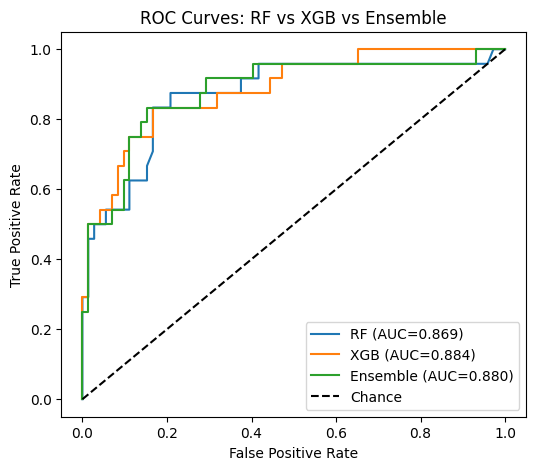

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Train an XGBoost on the enriched meta_all_tr features
xgb_clf = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    scale_pos_weight=(len(ytr) - ytr.sum()) / ytr.sum(),
    use_label_encoder=False,
    eval_metric='auc',
    random_state=42
)
xgb_clf.fit(meta_all_tr, ytr)

# Evaluate XGBoost
p_xgb_te = xgb_clf.predict_proba(meta_all_te)[:, 1]
y_xgb_pred = (p_xgb_te > 0.5).astype(int)
acc_xgb = accuracy_score(yte, y_xgb_pred)
auc_xgb = roc_auc_score(yte, p_xgb_te)
print(f"XGBoost acc: {acc_xgb:.2%}, ROC-AUC: {auc_xgb:.3f}")
print(pd.DataFrame(
    confusion_matrix(yte, y_xgb_pred),
    index=['True 0','True 1'], columns=['Pred 0','Pred 1']
))

# Build a soft-voting ensemble of RF and XGB
vot_clf = VotingClassifier(
    estimators=[('rf', best_rf), ('xgb', xgb_clf)],
    voting='soft',
    weights=[1, 1],
    n_jobs=-1
)
vot_clf.fit(meta_all_tr, ytr)

# Evaluate ensemble
p_vot_te = vot_clf.predict_proba(meta_all_te)[:, 1]
y_vot_pred = (p_vot_te > 0.5).astype(int)
acc_vot = accuracy_score(yte, y_vot_pred)
auc_vot = roc_auc_score(yte, p_vot_te)
print(f"Voting ensemble acc: {acc_vot:.2%}, ROC-AUC: {auc_vot:.3f}")
print(pd.DataFrame(
    confusion_matrix(yte, y_vot_pred),
    index=['True 0','True 1'], columns=['Pred 0','Pred 1']
))

# Plot ROC curves for RF, XGB, and Ensemble
from sklearn.metrics import roc_curve
plt.figure(figsize=(6,5))
for name, probs in [('RF', best_rf.predict_proba(meta_all_te)[:,1]),
                    ('XGB', p_xgb_te),
                    ('Ensemble', p_vot_te)]:
    fpr, tpr, _ = roc_curve(yte, probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(yte, probs):.3f})")
plt.plot([0,1],[0,1],'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves: RF vs XGB vs Ensemble')
plt.legend()
plt.show()


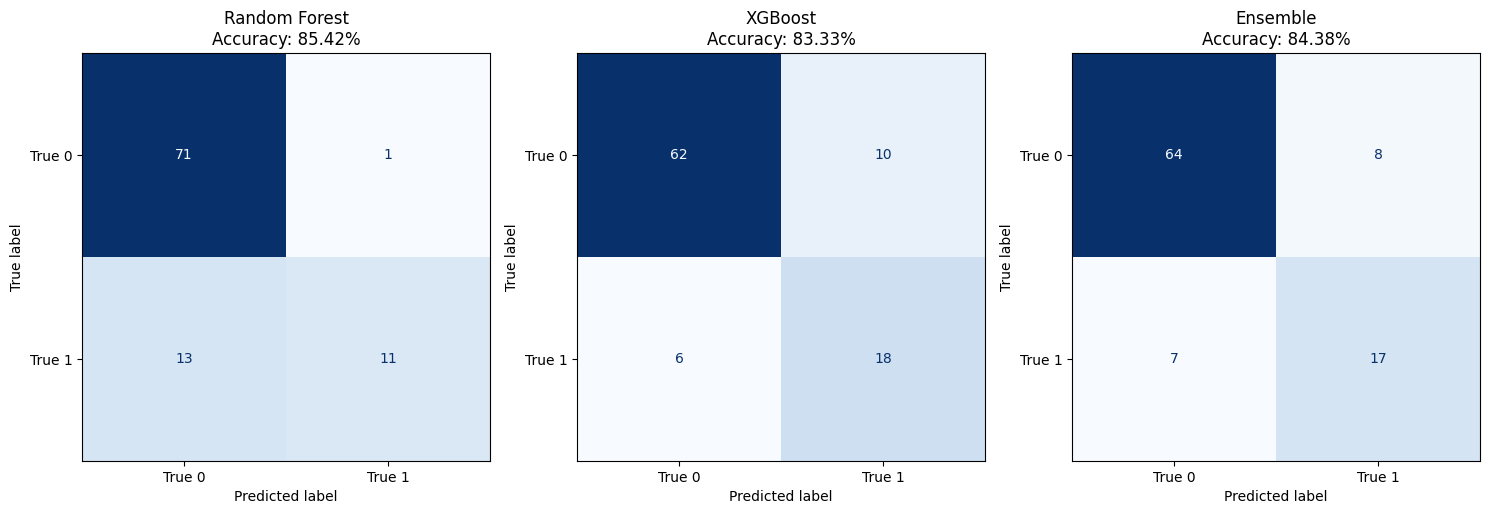

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Define your models
models = {
    'Random Forest': best_rf,
    'XGBoost': xgb_clf,
    'Ensemble': vot_clf
}

# Create a 1×3 grid for plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Generate and display each confusion matrix
for ax, (name, model) in zip(axes, models.items()):
    y_pred = model.predict(meta_all_te)
    cm = confusion_matrix(yte, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=['True 0', 'True 1'])
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    acc = accuracy_score(yte, y_pred)
    ax.set_title(f'{name}\nAccuracy: {acc:.2%}')

plt.tight_layout()
plt.show()


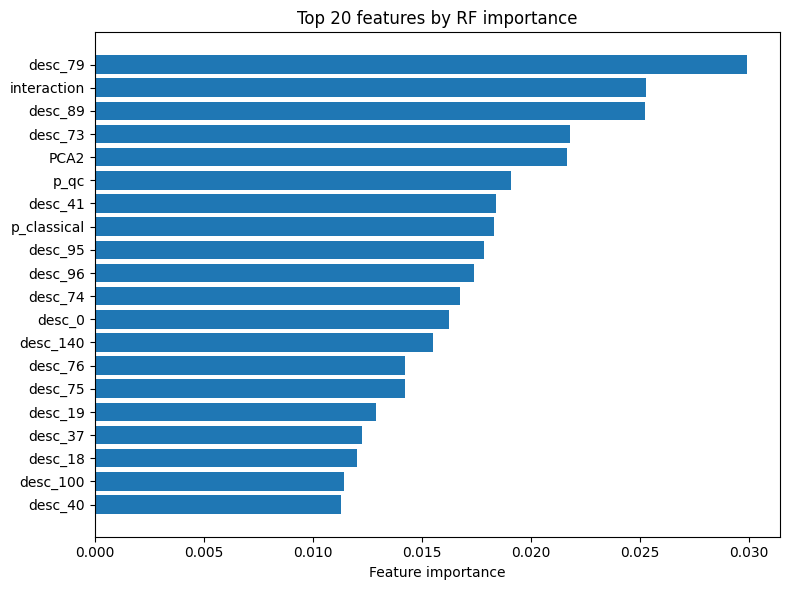

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

rf_all.fit(meta_all_tr, ytr)

# Build the feature‐name list in the same order you stacked them:
orig_names   = [f'desc_{i}'   for i in range(X_full_tr.shape[1])]
pca_names    = [f'PCA{i+1}'    for i in range(Xtr.shape[1])]
other_names  = ['p_classical','p_qc','interaction']
feature_names = orig_names + pca_names + other_names

# Grab importances (now that rf_all is fitted)
importances = rf_all.feature_importances_
indices     = np.argsort(importances)[::-1]  # descending

# Plot the top 20
top_n = min(20, len(importances))
plt.figure(figsize=(8,6))
plt.barh(
    [feature_names[i] for i in indices[:top_n]][::-1],
    importances[indices[:top_n]][::-1]
)
plt.xlabel('Feature importance')
plt.title(f'Top {top_n} features by RF importance')
plt.tight_layout()
plt.show()

### Make sure to Install these packages to do the demo


# pip install  qiskit qiskit-aer qiskit-machine-learning scikit-learn pandas

# Please also have the DIA_trainingset_RDKit_descriptors.csv in the same directory, as well as the opt_w.npy (opt_w.npy will be in your directory once the cell below is ran)

In [ ]:
# --- save out your trained weights ---
import numpy as np

np.save('opt_w.npy', opt_w)
print("✅ saved opt_w.npy")

# --- generate demo.py ---
demo = """import numpy as np
import pandas as pd
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, TwoLocal
from qiskit.quantum_info import Statevector, SparsePauliOp

# Rebuild your feature‐map & ansatz
nq, reps = 3, 3
fmap   = ZZFeatureMap(feature_dimension=nq, reps=reps)
ansatz = TwoLocal(
    num_qubits=nq,
    rotation_blocks=['ry'],
    entanglement_blocks='cz',
    reps=reps,
)

# Make a single template circuit
qc_template = QuantumCircuit(nq)
qc_template.append(fmap,   range(nq))
qc_template.append(ansatz, range(nq))

# Your measurement operator (Z⊗…⊗Z)
Zop = SparsePauliOp.from_list([('Z'*nq, 1)])

# Load the optimized weights
opt_w = np.load('opt_w.npy')

def predict_probs(X):
    out = []
    for x in X:
        # build one map for fmap params, one for ansatz params
        bind_map = {p: float(v) for p, v in zip(fmap.parameters,   x)}
        bind_map.update({p: float(v) for p, v in zip(ansatz.parameters, opt_w)})
        # assign all at once
        qc = qc_template.assign_parameters(bind_map)
        sv = Statevector.from_instruction(qc)
        ev = sv.expectation_value(Zop).real
        # convert ⟨Z⟩ ∈ [–1,1] to probability ∈ [0,1]
        out.append((1 - ev) / 2)
    return np.array(out)

def main():
    # load fresh data
    df = pd.read_csv('DIA_trainingset_RDKit_descriptors.csv')
    # drop the two non‐numeric columns
    df.drop(columns=['Label', 'SMILES'], inplace=True, errors='ignore')
    # now everything left is numeric
    X = df.values

    p = predict_probs(X)
    print("Quantum model probabilities:", p)

if __name__ == '__main__':
    main()
"""

with open('demo.py', 'w') as f:
    f.write(demo)

print("✨ demo.py written. Run it with `python demo.py`")


✅ saved opt_w.npy
✨ demo.py written. Run it with `python demo.py`
